In [ ]:
%reset

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# 获取数据集（具有正态分布的）
x_1_1 = pd.Series(np.random.normal(loc=22, scale=4, size=50), name='x1')
x_1_2 = pd.Series(np.random.normal(loc=24, scale=4, size=50), name='x2')
y_1 = pd.Series(['blue'] * 50, name='target')

x_2_1 = pd.Series(np.random.normal(loc=8, scale=3, size=50), name='x1')
x_2_2 = pd.Series(np.random.normal(loc=12, scale=3, size=50), name='x2')
y_2 = pd.Series(['red'] * 50, name='target')

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(x_1_1, x_1_2, c='blue')
plt.scatter(x_2_1, x_2_2, c='red')
plt.show()

tmp_data_1 = pd.concat([x_1_1, x_1_2, y_1], axis=1)
tmp_data_2 = pd.concat([x_2_1, x_2_2, y_2], axis=1)
data = pd.concat([tmp_data_1, tmp_data_2], axis=0)
data = shuffle(data).reset_index(drop=True)  # 打乱样本顺序

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1])

# 归一化
transfer = MinMaxScaler(feature_range=(0, 10))
x_train = transfer.fit_transform(X=x_train)
x_test = transfer.transform(X=x_test)


# CUC 的主类

In [2]:
import numpy as np
import pandas as pd
from enum import Enum
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


class CodingUnitClassifier(object):
    """编码单元分类器预估器（estimator）"""
    class CUType(Enum):
        NOT_FINAL_CU = -1
        EMPTY_CU = -2

    def __init__(self, num_refinement_splits=0, threshold_value=1.0, is_draw_2D=False, color_map=[], pic_save_path=None, **kw) -> None:
        """初始化

        Args:
            num_refinement_splits (int, optional): 细化分割次数. Defaults to 0.
            threshold_value (int, optional): 临界值. Defaults to  1.0.
            is_draw_2D (bool, optional): 当绘制 2D 数据集，是否绘制中途图像. Defaults to False.
        """
        self.is_draw_2D = is_draw_2D
        self.pic_save_path = pic_save_path
        self.color_map = color_map
        self.draw_count = 0  # 绘制次数记录（还用于拓展保存时的文件名）

        self.split_count = 0  # 分割次数计数器
        self.num_refinement_splits = num_refinement_splits
        self.threshold_value = threshold_value  # 临界值：当某个 CU 中某种粒子占比超过这个阈值，则暂停分割

        self.transfer_LabelEncoder = None  # 目标值的转换器（转为数字）

        self.N_train = None  # 训练集的维度
        self.X_train = None  # 特征值（训练集）
        self.y_train = None  # 目标值（训练集）
        self.df_train = None  # 以 pandas.DataFream 形式的训练接数据（特征值和训练集是合并在一起的）。目标值的索引为 `target`，特征值的索引为 `x`，x 为从 0 开始的数字

        self.CU_min = None  # 编码单元范围最小值
        self.CU_max = None  # 编码单元范围最小值

        self.arrCU_start_points = None  # 编码单元起始点列表
        self.arrCU_dL = None  # arrCU_start_points 对应位置的编码单元的边长 `dL`
        self.arrCU_is_enable = None  # arrCU_start_points 对应位置的编码单元是否启用，True 代表启用，False 代表不启用
        self.arrCU_final_target = None  # arrCU_start_points 对应位置的编码单元的最终预测类别（-1 代表无类别）
        self.arrCU_num_point = None # arrCU_start_points 对应位置的编码单元中粒子数量
        self.arrCU_force_infection = None  # arrCU_start_points 对应位置的编码单元的感染力度 (force of infection)
        self.arrCU_is_been_I = None  # 当前单元是否成为过感染者（I）

    def arr_checker(self):
        """
        检测当前 self 内数组的长度是否正常
        :return:
        """
        if self.arrCU_start_points.shape[0] != self.arrCU_dL.shape[0] != self.arrCU_is_enable.shape[0] != \
                self.arrCU_final_target.shape[0]:
            raise ValueError(f'arrCU 长度异常：\n'
                             f'\t{self.arrCU_start_points.shape[0]}'
                             f'\t{self.arrCU_dL.shape[0]}'
                             f'\t{self.arrCU_is_enable.shape[0]}'
                             f'\t{self.arrCU_final_target.shape[0]}')

    def is_point_in_CU(self, point: np.ndarray, start_point: np.ndarray, dL: float) -> bool:
        """
        判断点（样本）point，是否在编码单元中
        :param point: 需要判断的点
        :param start_point: 编码单元的起始点
        :param dL: 编码单元的边长
        :return: True-在这个 CU 中；False：不在这个 CU 中
        """
        point = np.array(point)
        start_point = np.array(start_point)
        end_point = np.array(start_point + dL)  # 结束点
        if (point > start_point).all() and (point < end_point).all():
            return True
        else:
            return False

    def predict_is_point_in_CU(self, point: np.ndarray, start_point: np.ndarray, dL: float) -> bool:
        """
        【仅供 fit 结束后预测阶段使用。因为需要预测的点可能落到编码单元的边缘】预测判断点（样本）point，是否在编码单元中
        :param point: 需要判断的点
        :param start_point: 编码单元的起始点
        :param dL: 编码单元的边长
        :return: True-在这个 CU 中；False：不在这个 CU 中
        """
        point = np.array(point)
        start_point = np.array(start_point)
        end_point = np.array(start_point + dL)  # 结束点
        if (point >= start_point).all() and (point <= end_point).all():
            return True
        else:
            return False

    def is_CU_need_split(self, arr1d_start_points: np.ndarray, dL: np.float) -> np.int:
        """判断当前 CU 是否需要继续预分割（如果需要返回 -1，如果不需要返回当前 CU 所属的目标值，并且 -2 代表为空白 CU）

        Args:
            arr1d_start_points (np.ndarray): 当前 CU 的起始点
            dL (np.float): 当前 CU 的边长

        Raises:
            ValueError: _description_
            ValueError: _description_

        Returns:
            _type_: True为需要进一步分割，如果不需要返回当前 CU 所属的目标值
        """
        if dL <= 0:
            raise ValueError(f'[CUC-ERROR] dl can not <= 0, your dL is {dL}')
        if arr1d_start_points.shape[0] != self.N_train:
            raise ValueError(
                f'[CUC-ERROR] arr1d_start_points.shape not correct: arr1d_start_points.shape is {arr1d_start_points.shape}, '
                f'should be ({self.N_train}, )')

        s_type_count = pd.Series(index=np.unique(self.y_train)).fillna(value=0)  # 计数器，列索引为类别，对应位置数据为该 CU 中此种类粒子数量

        # 遍历判断点是否在这个 CU  中
        for col, col_target in zip(self.X_train, self.y_train):  # col_target 为当前行的目标值
            # 判断粒子在此维度上是否介于 CU 的起始点和结束点
            if self.is_point_in_CU(point=col, start_point=arr1d_start_points, dL=dL):
                s_type_count[col_target] += 1

        # -1 代表这个编码单元里没有任何粒子，为空白编码单元
        if 0 == s_type_count.sum():
            return self.CUType.EMPTY_CU.value

        # 如果不是空 CU，则看看某种 target 的粒子占比是否达到阈值
        s_type_count = s_type_count / s_type_count.sum()  # 转换为概率
        if (s_type_count.max() >= self.threshold_value) and \
                (1 == s_type_count[s_type_count.values == s_type_count.max()].shape[0]):  # 不允许出现两种相同概率
            return s_type_count[s_type_count.values == s_type_count.max()].index[0]
        else:
            return self.CUType.NOT_FINAL_CU.value

    def split_CU_and_update2arrCU(self, index_start_points: int) -> None:
        """分割当前 CU，并将分割的结果更新到方法内部成员

        Args:
            index_start_points (int): 需要分割 CU 的索引
        """
        if not self.arrCU_is_enable[index_start_points]:
            raise ValueError(f'[CUC-ERROR] CU on index {index_start_points} already disable, can not continue split')

        self.arrCU_is_enable[index_start_points] = False  # 既然对这个单元分割就说明这个单元不再使用了，因为它被差分成了许多新的小单元
        # if self.arrCU_is_enable[index_start_points]:
        #     print('>>>>>>>>>>>>>>>>>>> ERROR >>>>>>>>>>>>>>>>>>>')

        start_points = self.arrCU_start_points[index_start_points]
        new_dL = self.arrCU_dL[index_start_points] / 2
        end_points = np.array(start_points + new_dL)

        # 生成包含所有可能性组合的列表
        combinations = []
        for i in range(2 ** self.N_train):
            new_combination = []
            for j in range(self.N_train):
                if i & (1 << j):
                    new_combination.append(end_points[j])
                else:
                    new_combination.append(start_points[j])
            combinations.append(new_combination)

        # print(f'\n\n[INFO] -------------split-------------\n'
        #       f'new_dL: {new_dL}\n'
        #       f'new_combination:\n{combinations}')

        # 分割后的 CU 添加至缓冲区
        self.arrCU_start_points = np.vstack([self.arrCU_start_points, np.array(combinations)])
        self.arrCU_dL = np.hstack([self.arrCU_dL, np.full(shape=(2 ** self.N_train,), fill_value=new_dL)])
        self.arrCU_is_enable = np.hstack([self.arrCU_is_enable, np.full(shape=(2 ** self.N_train,), fill_value=True)])
        self.arrCU_final_target = np.hstack(
            [self.arrCU_final_target,
             np.full(shape=(2 ** self.N_train,), fill_value=self.arrCU_final_target[index_start_points], dtype=np.int)])

        self.split_count += 1

    def remove_disable_points(self):
        """
        删除 arr 群组中 disable 的 point
        :return:
        """
        # 移除 self arr 数组群中 disable 的 CU，
        # 同时重新标记细化分割中产生的新空白 CU（原含有粒子的大 CU 被重新切分后可能会产生不包含粒子的新 CU）
        # 同时计算 CU 的密度
        df_X_target = pd.DataFrame(self.X_train)

        new_arrCU_start_points = None  # 编码单元起始点列表
        new_arrCU_dL = None  # arrCU_start_points 对应位置的编码单元的边长 `dL`
        new_arrCU_is_enable = None  # arrCU_start_points 对应位置的编码单元是否启用，True 代表启用，False 代表不启用
        new_arrCU_final_target = None  # arrCU_start_points 对应位置的编码单元的最终预测类别（-1 代表无类别）
        new_arrCU_num_point = None  # arrCU_start_points 对应位置的编码单元中粒子数量
        new_arrCU_force_infection = None  # arrCU_start_points 对应位置的编码单元的感染力度 (force of infection)

        for i in range(self.arrCU_start_points.shape[0]):
            if not self.arrCU_is_enable[i]:
                continue
            dL = self.arrCU_dL[i]
            start_point = np.array(self.arrCU_start_points[i])
            end_point = np.array(start_point + dL)

            # 计算该单元中粒子的数量
            tmp_s_is_X_in_CU = ((df_X_target > start_point) & (df_X_target < end_point)).all(axis=1)  # all代表按行判断是否这一行都为 True（也就是 point 每个对应维度都符合），返回对应位置为 True/False 的 pd.Series
            num_point_in_CU = tmp_s_is_X_in_CU[tmp_s_is_X_in_CU == True].count()  # 该单元中粒子的数量
            target_CU = None  # 编码单元的类别
            density = None  # 密度（感染力度）

            # CU 中无粒子
            if 0 == num_point_in_CU:
                density = 0.0
                target_CU = self.CUType.EMPTY_CU.value
            else:
                density = num_point_in_CU / (dL ** self.N_train)
                target_CU = self.arrCU_final_target[i]

            # 第一个 enable 的 CU（也就是初始化 new_arr）
            if new_arrCU_is_enable is None:
                new_arrCU_start_points = np.array([self.arrCU_start_points[i]])
                new_arrCU_dL = np.array(self.arrCU_dL[i])
                new_arrCU_is_enable = np.array(self.arrCU_is_enable[i])
                new_arrCU_final_target = np.array(target_CU)
                new_arrCU_num_point = np.array(num_point_in_CU)
                new_arrCU_force_infection = np.array(density)
                continue

            new_arrCU_start_points = np.vstack([new_arrCU_start_points, np.array(self.arrCU_start_points[i])])
            new_arrCU_dL = np.append(new_arrCU_dL, self.arrCU_dL[i])
            new_arrCU_is_enable = np.append(new_arrCU_is_enable, self.arrCU_is_enable[i])
            new_arrCU_final_target = np.append(new_arrCU_final_target, target_CU)
            new_arrCU_num_point = np.append(new_arrCU_num_point, num_point_in_CU)
            new_arrCU_force_infection = np.append(new_arrCU_force_infection, density)

        del self.arrCU_start_points
        del self.arrCU_dL
        del self.arrCU_is_enable
        del self.arrCU_final_target
        del self.arrCU_num_point
        del self.arrCU_force_infection

        self.arrCU_start_points = new_arrCU_start_points
        self.arrCU_dL = new_arrCU_dL
        self.arrCU_is_enable = new_arrCU_is_enable
        self.arrCU_final_target = new_arrCU_final_target
        self.arrCU_num_point = new_arrCU_num_point
        self.arrCU_force_infection = new_arrCU_force_infection

    def pre_split(self):
        """
        预分割阶段
        :return:
        """
        # 预分割阶段
        current_index = 0
        while current_index < self.arrCU_start_points.shape[0]:
            self.arr_checker()

            # 如果当前 CU 已经废弃（disable），那么就没有再对他进行处理的意义了
            if not self.arrCU_is_enable[current_index]:
                current_index += 1
                continue

            # 如果当前 CU 启用，但是已经有了最终类别
            if self.arrCU_is_enable[current_index] and self.arrCU_final_target[current_index] != self.CUType.NOT_FINAL_CU.value:
                current_index += 1
                continue

            cur_target = self.is_CU_need_split(arr1d_start_points=self.arrCU_start_points[current_index],
                                               dL=self.arrCU_dL[current_index])
            print(f'[INFO] CUC.fit(): current_index: {current_index} \t cur_target: {cur_target}')

            if cur_target == self.CUType.NOT_FINAL_CU.value:
                self.split_CU_and_update2arrCU(index_start_points=current_index)
            else:
                self.arrCU_is_enable[current_index] = True
                self.arrCU_final_target[current_index] = cur_target
                if self.N_train == 2 and self.is_draw_2D:
                    self.draw_2d(color_map=self.color_map, pic_save_path=self.pic_save_path)

            current_index += 1
            # print(f'\n>>>>>>>>>>>>>>>> 预分割阶段 {current_index}')
            # res = pd.concat([pd.DataFrame(self.arrCU_start_points),
            #                  pd.Series(self.arrCU_is_enable),
            #                  pd.Series(self.arrCU_dL),
            #                  pd.Series(self.arrCU_final_target)], axis=1)
            # res.columns = ('x', 'y', 'is_enable', 'dL', 'target')
            # print(res)

    def refinement_split(self, num: int) -> None:
        """
        细化分割
        :param num:细化分割的次数
        :return: None
        """
        self.arr_checker()  # 执行数组长度一致性检查

        for run_time in range(num):
            # 对每个 enable 的 CU 进行细化分割
            for i in range(self.arrCU_start_points.shape[0]):
                if not self.arrCU_is_enable[i]:
                    continue
                self.split_CU_and_update2arrCU(index_start_points=i)

    def is_overlapping(self, point_1_start: float, point_1_end: float, point_2_start: float, point_2_end: float) -> bool:
        """判断某个维度的投影下，两个水平的线段是否相交

        Args:
            point_1_start (float): point1的起始点（CU某个维度上的最小值）
            point_1_end (float): point1的结束点（CU某个维度上的最大值）
            point_2_start (float): point2的起始点（CU某个维度上的最小值）
            point_2_end (float): point2的结束点（CU某个维度上的最大值）

        Returns:
            bool: True 代表相交，False 代表不相交
        """
        return (point_1_end >= point_2_start) and (point_2_end >= point_1_start)

    def infection(self) -> None:
        """
        感染阶段
        :return: 无
        """
        self.arr_checker()

        self.arrCU_is_been_I = np.full(shape=self.arrCU_is_enable.shape, fill_value=False)  # False 代表从来没感染过他人
        run_time = 0
        # 如果还有空白的编码单元就一直循环
        while np.any(self.arrCU_final_target == self.CUType.EMPTY_CU.value):
            run_time += 1
            # 获取没有使用过的感染者
            index_I = None  # 当前的感染者是感染力度最大的，这里获取他的下标
            tmp_fi_max = -1.0
            for i in range(self.arrCU_is_enable.shape[0]):
                if self.arrCU_is_been_I[i] or self.arrCU_force_infection[i] <= tmp_fi_max:
                    continue
                index_I = i
                tmp_fi_max = self.arrCU_force_infection[i]

            # 感染力度最大的单元去感染其他粒子
            # I - 感染者，他去感染其他单元
            # S - 被感染者，他被 I 所感染
            # index_I = self.arrCU_force_infection.argmax()  #
            self.arrCU_is_been_I[index_I] = True
            target_I = self.arrCU_final_target[index_I]
            start_point_I = self.arrCU_start_points[index_I]
            end_point_I = np.array(start_point_I + self.arrCU_dL[index_I])

            # 遍历所有 CU，当前感染者I 要去感染CU（被感染者 S）的 index
            arr_index_S = np.array(index_I)
            sum_point = self.arrCU_num_point[index_I]  # 所有被感染者CU中的粒子数量
            sum_V = (self.arrCU_dL[index_I] ** self.N_train)  # 所有被感染者CU中的体积
            for i in range(self.arrCU_start_points.shape[0]):
                # 当前 CU 已经是别的target，并且不是空白 CU
                if (self.arrCU_final_target[i] != target_I) and (self.arrCU_final_target[i] != self.CUType.EMPTY_CU.value):
                    continue
                # 不能自己感染自己
                if i == index_I:
                    continue

                start_point_S = self.arrCU_start_points[i]
                end_point_S = np.array(start_point_S + self.arrCU_dL[i])

                # 判断每一维度（数列-D 表示特征）的投影是否都相交
                same_d_count = 0  # 如果某个维度上相等（same_d_count = self.N_train），则 +1，如果每个维度上的投影都相交，则说明两个 CU 重叠
                for d in range(self.N_train):
                    if self.is_overlapping(point_1_start=start_point_I[d], point_1_end=end_point_I[d],
                                           point_2_start=start_point_S[d], point_2_end=end_point_S[d]):
                        same_d_count += 1
                    else:
                        break

                # 如果 I 与 S 不相邻，直接进行下一次迭代
                if same_d_count != self.N_train:
                    continue

                # 记录被感染者 S 的下标
                arr_index_S = np.append(arr_index_S, i)
                sum_point += self.arrCU_num_point[i]
                sum_V += (self.arrCU_dL[i] ** self.N_train)

            # 【感染】如果相邻，则进行感染，并且重置他们的感染力度和单元类别 >>>>>>>>>>>>>>>>>
            print(f'[INFO] CU_{index_I} 将感染 {arr_index_S}, {arr_index_S.shape}')
            if arr_index_S.shape == ():  # 可能出现空的情况
                continue

            new_fi = sum_point / sum_V  # 新感染力度
            for i in arr_index_S:
                self.arrCU_force_infection[i] = new_fi
                self.arrCU_final_target[i] = target_I
            # <<<<<<<<<<<<<<<<<< 感染结束
            if self.is_draw_2D and (2 == self.N_train):
                self.draw_2d(color_map=self.color_map, pic_save_path=self.pic_save_path)

    def draw_2d(self, color_map, pic_save_path=None) -> None:
        """
        绘制 2D 图形
        :param color_map:
        :param pic_save_path:
        :return:
        """
        # self.draw_count += 1
        # if self.draw_count > 70 and self.draw_count % 10 != 0:
        #     return

        color_map = np.array(color_map)
        if color_map.shape[0] != self.N_train:
            raise ValueError('\n[CUC-ERROR] color_map.shape[0] != self.N_train')

        plt.figure(figsize=(5, 5))

        # 绘制点
        tmp_data = pd.concat([pd.DataFrame(self.X_train), pd.Series(self.y_train)], axis=1)
        tmp_data.columns = ('x', 'y', 'target')
        for target in np.unique(self.y_train):
            plt.scatter(tmp_data[tmp_data['target'] == target].values[:, 0],
                        tmp_data[tmp_data['target'] == target].values[:, 1], c=color_map[target], s=5)

        for i in range(self.arrCU_start_points.shape[0]):
            target = self.arrCU_final_target[i]
            # 如果当前 CU 不是最终的，或者是 disable 的，那么没有绘制的必要
            if (target == self.CUType.NOT_FINAL_CU.value) or (self.arrCU_is_enable[i] is False):
                continue

            start_points = self.arrCU_start_points[i]
            dL = self.arrCU_dL[i]
            t_x_block = [start_points[0], start_points[0] + dL, start_points[0] + dL, start_points[0]]
            t_y_block = [start_points[1], start_points[1],      start_points[1] + dL, start_points[1] + dL]

            # plt.plot(t_x_block, t_y_block, c='black')  # 黑色边框
            if self.CUType.EMPTY_CU.value == target:
                plt.fill(t_x_block, t_y_block, c='grey', alpha=0.2)
            else:
                plt.fill(t_x_block, t_y_block, c=color_map[target], alpha=0.2)
            plt.title(f'Splitting process in CUC\n(splits count {self.split_count})')
            plt.ylabel('y')
            plt.xlabel('x')
            plt.axis('equal')  # x、y 单位长度等长

        self.draw_count += 1
        if pic_save_path is not None:
            plt.savefig(f'{pic_save_path}-{self.draw_count}.png')
        plt.show()
        plt.close('all')  # 必须手动释放内存，不然当需要绘制很多图形时会导致内存泄漏

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """编码单元分类器的估计器（estimator）

        Args:
            X (np.ndarray): 特征值
            y (np.ndarray): 目标值

        Raises:
            ValueError: _description_
        """
        # 如果特征值和目标值维度相等
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'[CUC-ERROR] X.shape != y.shape: X.shape is {X.shape[0]}, y.shape is {y.shape[0]}')

        # =================================== 初始化 CUC 配置参数 ===================================
        self.N_train = X.shape[1]
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.df_train = pd.concat([pd.DataFrame(self.X_train), pd.Series((self.y_train), name='target')], axis=1)

        self.CU_min = X.min()
        self.CU_max = X.max()

        # 目标值转为数值类型
        self.transfer_LabelEncoder = LabelEncoder()
        self.y_train = np.array(self.transfer_LabelEncoder.fit_transform(y=y), dtype=np.int)

        # 初始化 CU 相关 ndarray
        self.arrCU_start_points = np.full(shape=(1, self.N_train), fill_value=self.CU_min)  # 将初始化中的 0.0 替换为编码单元的起始点
        self.arrCU_dL = np.array([self.CU_max - self.CU_min])
        self.arrCU_is_enable = np.array([True])
        self.arrCU_final_target = np.array([self.CUType.NOT_FINAL_CU.value], dtype=np.int)
        self.arrCU_force_infection = np.array([np.nan])
        # =========================================================================================


        # ========================================= 预分割 =========================================
        self.pre_split()
        self.remove_disable_points()

        print('\n>>>>>>>>>>>>>>>> 完成预分割后的arr结果')
        res = pd.concat([pd.DataFrame(self.arrCU_start_points),
                         pd.Series(self.arrCU_is_enable),
                         pd.Series(self.arrCU_dL),
                         pd.Series(self.arrCU_final_target),
                         pd.Series(self.arrCU_force_infection)], axis=1)
        res.columns = ('x', 'y', 'is_enable', 'dL', 'target', 'force_infection')
        print(res)
        # =========================================================================================


        # ========================================= 细化分割 =========================================
        self.refinement_split(num=self.num_refinement_splits)
        self.remove_disable_points()
        if self.N_train == 2 and self.is_draw_2D:
            self.draw_2d(color_map=self.color_map, pic_save_path=self.pic_save_path)

        print('\n>>>>>>>>>>>>>>>> 完成细化分割后的arr结果')
        res = pd.concat([pd.DataFrame(self.arrCU_start_points),
                         pd.Series(self.arrCU_is_enable),
                         pd.Series(self.arrCU_dL),
                         pd.Series(self.arrCU_final_target),
                         pd.Series(self.arrCU_force_infection)], axis=1)
        res.columns = ('x', 'y', 'is_enable', 'dL', 'target', 'force_infection')
        print(res)
        # =========================================================================================

        self.infection()

    def predict(self, X: np.ndarray) -> list:
        if X.shape[1] != self.N_train:
            raise ValueError(f'[CUC-ERROR] In method predict: X.shape != self.N_train: X.shape is {X.shape[1]}, y.shape is {self.N_train}')

        res_predict = []
        for x in X:
            for i in range(self.arrCU_start_points.shape[0]):
                if self.predict_is_point_in_CU(point=x, start_point=self.arrCU_start_points[i], dL=self.arrCU_dL[i]):
                    res_predict.append(self.transfer_LabelEncoder.classes_[self.arrCU_final_target[i]])
                    break

        return res_predict


In [3]:
estimator = CodingUnitClassifier(num_refinement_splits=1, is_draw_2D=False, color_map=('blue', 'red'))
estimator.fit(X=x_train, y=y_train)
estimator.draw_2d(color_map=('blue', 'red'))

NameError: name 'x_train' is not defined

# 绘制结果

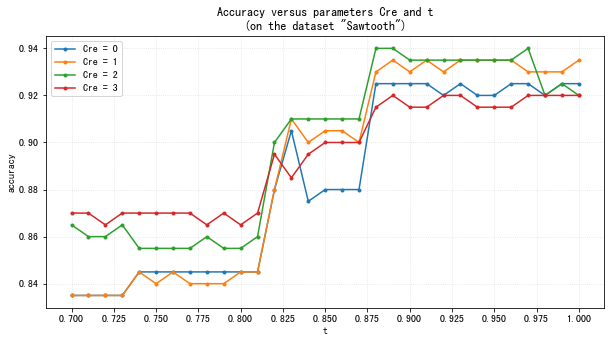

In [98]:
# 细化分割次数和临界值对准确率的影响
x = np.arange(start=0.7, stop=1.0, step=0.01)

# forclass
# y_0 = [0.8084112149532711, 0.8084112149532711, 0.8084112149532711, 0.8738317757009346, 0.8691588785046729, 0.8738317757009346, 0.8691588785046729, 0.8785046728971962, 0.8691588785046729, 0.8738317757009346, 0.8785046728971962, 0.897196261682243, 0.9018691588785047, 0.9018691588785047, 0.9112149532710281, 0.9018691588785047, 0.9065420560747663, 0.9065420560747663, 0.9299065420560748, 0.9252336448598131, 0.9299065420560748, 0.9252336448598131, 0.9345794392523364, 0.9299065420560748, 0.9392523364485982, 0.9532710280373832, 0.9532710280373832, 0.9485981308411215, 0.9439252336448598, 0.9532710280373832, 0.9485981308411215]
# y_1 = [0.8130841121495327, 0.8130841121495327, 0.8084112149532711, 0.8785046728971962, 0.8785046728971962, 0.8785046728971962, 0.883177570093458, 0.883177570093458, 0.883177570093458, 0.8785046728971962, 0.8785046728971962, 0.9018691588785047, 0.9112149532710281, 0.9018691588785047, 0.9112149532710281, 0.8878504672897196, 0.8878504672897196, 0.8925233644859814, 0.9112149532710281, 0.9112149532710281, 0.9158878504672897, 0.9158878504672897, 0.9205607476635514, 0.9158878504672897, 0.9252336448598131, 0.9392523364485982, 0.9345794392523364, 0.9392523364485982, 0.9345794392523364, 0.9392523364485982, 0.9439252336448598]
# y_2 = [0.8504672897196262, 0.8411214953271028, 0.8504672897196262, 0.9205607476635514, 0.9112149532710281, 0.9205607476635514, 0.9205607476635514, 0.9112149532710281, 0.9205607476635514, 0.9158878504672897, 0.9205607476635514, 0.9299065420560748, 0.9345794392523364, 0.9345794392523364, 0.9392523364485982, 0.9205607476635514, 0.9205607476635514, 0.9299065420560748, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.9392523364485982, 0.9392523364485982, 0.9485981308411215, 0.9532710280373832, 0.9485981308411215, 0.9439252336448598, 0.9485981308411215, 0.9485981308411215, 0.9532710280373832, 0.9532710280373832]
# y_3 = [0.8878504672897196, 0.883177570093458, 0.8878504672897196, 0.9205607476635514, 0.9205607476635514, 0.9205607476635514, 0.9205607476635514, 0.9158878504672897, 0.9205607476635514, 0.9205607476635514, 0.9252336448598131, 0.9439252336448598, 0.9392523364485982, 0.9392523364485982, 0.9439252336448598, 0.9392523364485982, 0.9392523364485982, 0.9392523364485982, 0.9439252336448598, 0.9532710280373832, 0.9532710280373832, 0.9485981308411215, 0.9485981308411215, 0.9532710280373832, 0.9579439252336449, 0.9579439252336449, 0.9626168224299065, 0.9626168224299065, 0.9532710280373832, 0.9579439252336449, 0.9626168224299065]


# checkboard
# y_0 = [0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.99625, 0.99625, 0.99375, 0.9875, 0.98625, 0.9725, 0.97, 0.9575, 0.95375, 0.95125, 0.95, 0.95, 0.95125, 0.95]
# y_1 = [0.99625, 0.99625, 0.9975, 0.9975, 0.9975, 0.99625, 0.9975, 0.99625, 0.99625, 0.99625, 0.99625, 0.99625, 0.9975, 0.99625, 0.99625, 0.9975, 0.9975, 0.99625, 0.995, 0.9925, 0.98875, 0.9875, 0.97, 0.97, 0.96125, 0.9525, 0.9475, 0.9475, 0.94875, 0.94875, 0.9475]
# y_2 = [0.9975, 0.9975, 0.99625, 0.9975, 0.99625, 0.9975, 0.99625, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.99625, 0.9975, 0.99625, 0.99625, 0.99625, 0.995, 0.995, 0.99375, 0.98875, 0.98875, 0.9775, 0.975, 0.9675, 0.96125, 0.96, 0.95875, 0.955, 0.955, 0.95625]
# y_3 = [0.9925, 0.99125, 0.9925, 0.99125, 0.99125, 0.99125, 0.9925, 0.99125, 0.9925, 0.9925, 0.99125, 0.99125, 0.99125, 0.99125, 0.99125, 0.99125, 0.9925, 0.99, 0.99125, 0.99125, 0.985, 0.985]

# 锯齿
y_0 = [0.835, 0.835, 0.835, 0.835, 0.845, 0.845, 0.845, 0.845, 0.845, 0.845, 0.845, 0.845, 0.88, 0.905, 0.875, 0.88, 0.88, 0.88, 0.925, 0.925, 0.925, 0.925, 0.92, 0.925, 0.92, 0.92, 0.925, 0.925, 0.92, 0.925, 0.925]
y_1 = [0.835, 0.835, 0.835, 0.835, 0.845, 0.84, 0.845, 0.84, 0.84, 0.84, 0.845, 0.845, 0.88, 0.91, 0.9, 0.905, 0.905, 0.9, 0.93, 0.935, 0.93, 0.935, 0.93, 0.935, 0.935, 0.935, 0.935, 0.93, 0.93, 0.93, 0.935]
y_2 = [0.865, 0.86, 0.86, 0.865, 0.855, 0.855, 0.855, 0.855, 0.86, 0.855, 0.855, 0.86, 0.9, 0.91, 0.91, 0.91, 0.91, 0.91, 0.94, 0.94, 0.935, 0.935, 0.935, 0.935, 0.935, 0.935, 0.935, 0.94, 0.92, 0.925, 0.92]
y_3 = [0.87, 0.87, 0.865, 0.87, 0.87, 0.87, 0.87, 0.87, 0.865, 0.87, 0.865, 0.87, 0.895, 0.885, 0.895, 0.9, 0.9, 0.9, 0.915, 0.92, 0.915, 0.915, 0.92, 0.92, 0.915, 0.915, 0.915, 0.92, 0.92, 0.92, 0.92]


# 双螺旋
# y_0 = [0.91, 0.915, 0.91, 0.915, 0.915, 0.915, 0.91, 0.915, 0.915, 0.925, 0.93, 0.925, 0.925, 0.93, 0.95, 0.95, 0.95, 0.95, 0.955, 0.955, 0.955, 0.96, 0.96, 0.96, 0.96, 0.97, 0.97, 0.975, 0.97, 0.975, 0.975]
# y_1 = [0.915, 0.915, 0.91, 0.91, 0.915, 0.915, 0.91, 0.915, 0.915, 0.945, 0.94, 0.945, 0.945, 0.945, 0.965, 0.96, 0.975, 0.97, 0.97, 0.97, 0.97, 0.985, 0.98, 0.985, 0.985, 0.98, 0.98, 0.985, 0.98, 0.985, 0.99] 
# y_2 = [0.945, 0.94, 0.94, 0.945, 0.945, 0.94, 0.945, 0.945, 0.945, 0.965, 0.965, 0.97, 0.97, 0.97, 0.985, 0.985, 0.98, 0.98, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.98, 0.985, 0.98, 0.985, 0.98, 0.99, 0.995] 
# y_3 = [0.95, 0.95, 0.95, 0.955, 0.95, 0.95, 0.95, 0.95, 0.955, 0.985, 0.98, 0.985, 0.985, 0.985, 0.995, 0.995, 0.995, 1.0, 1.0, 0.995, 1.0, 1.0, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 0.99, 0.99]


plt.figure(figsize=(10, 5))
plt.plot(x, y_0, label='Cre = 0', marker='.')
plt.plot(x, y_1, label='Cre = 1', marker='.')
plt.plot(x, y_2, label='Cre = 2', marker='.')
plt.plot(x, y_3, label='Cre = 3', marker='.')

# plt.title('Accuracy versus parameters Cre and t\n(on the dataset "fourclass")')
# plt.title('Accuracy versus parameters Cre and t\n(on the dataset "Checkerboard")')
plt.title('Accuracy versus parameters Cre and t\n(on the dataset "Sawtooth")')
# plt.title('Accuracy versus parameters Cre and t\n(on the dataset "DoubleHelix")')

plt.xlabel('t')
plt.ylabel('accuracy')
plt.xticks(np.arange(start=0.70, stop=1.0, step=0.025))
plt.legend()
plt.grid(linestyle=':', alpha=0.4)

# plt.savefig('./output/res-score-fourclass.png')
# plt.savefig('./output/res-score-Checkerboard.png')
plt.savefig('./output/res-score-Sawtooth.png')
# plt.savefig('./output/res-score-DoubleHelix.png')


plt.show()

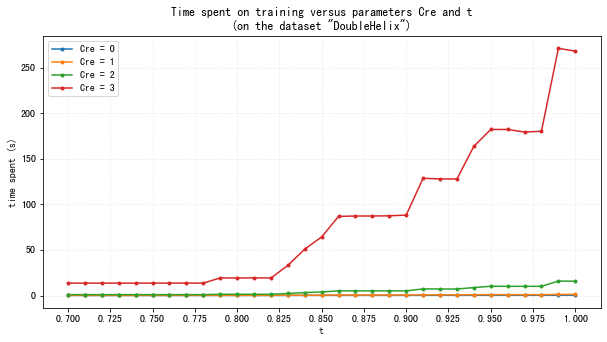

In [96]:
# 细化分割次数和临界值对时间影响
x = np.arange(start=0.7, stop=1.0, step=0.01)

# y_0 = [0.16258907318115234, 0.050511837005615234, 0.0513153076171875, 0.09566807746887207, 0.09372687339782715, 0.09861612319946289, 0.09542107582092285, 0.09567904472351074, 0.12135767936706543, 0.09232592582702637, 0.09411096572875977, 0.11740589141845703, 0.1237177848815918, 0.12362098693847656, 0.20554494857788086, 0.3201577663421631, 0.31068897247314453, 0.30437207221984863, 0.3314840793609619, 0.3710918426513672, 0.34897804260253906, 0.3493039608001709, 0.37132906913757324, 0.36652302742004395, 0.38936400413513184, 0.41066503524780273, 0.4108757972717285, 0.4076998233795166, 0.4513528347015381, 0.4456210136413574, 0.4373641014099121]
# y_1 = [0.06305193901062012, 0.06038212776184082, 0.06295204162597656, 0.12362384796142578, 0.12568306922912598, 0.14905905723571777, 0.13094592094421387, 0.12830901145935059, 0.13071799278259277, 0.1482079029083252, 0.12176012992858887, 0.15924882888793945, 0.1976761817932129, 0.1854851245880127, 0.3004031181335449, 0.47258687019348145, 0.5230839252471924, 0.49907684326171875, 0.5546138286590576, 0.6075201034545898, 0.6103370189666748, 0.5846400260925293, 0.6514170169830322, 0.6334500312805176, 0.7043299674987793, 0.7309198379516602, 0.7507777214050293, 0.7267360687255859, 0.8223130702972412, 0.8315169811248779, 0.8226308822631836]
# y_2 = [0.13301491737365723, 0.13851690292358398, 0.1393752098083496, 0.3680851459503174, 0.3564620018005371, 0.3579862117767334, 0.3556668758392334, 0.36194610595703125, 0.3569169044494629, 0.3570399284362793, 0.3861100673675537, 0.5024278163909912, 0.5336267948150635, 0.5026757717132568, 1.3813769817352295, 2.807469129562378, 3.011647939682007, 2.9812281131744385, 3.3555290699005127, 3.7774159908294678, 3.8303141593933105, 3.8058080673217773, 4.235689163208008, 4.309155225753784, 4.718774795532227, 5.217462778091431, 5.256882905960083, 5.289380073547363, 6.314023017883301, 6.353825092315674, 6.3533689975738525]
# y_3 = [0.8031790256500244, 0.8060739040374756, 0.8398218154907227, 3.2075891494750977, 3.199896812438965, 3.2357797622680664, 3.2195987701416016, 3.214832067489624, 3.2273049354553223, 3.201352834701538, 3.220921039581299, 4.928184747695923, 4.980514049530029, 4.9587578773498535, 17.48303985595703, 39.4122269153595, 42.340973138809204, 42.299853801727295, 48.75856900215149, 55.357131004333496, 56.37722396850586, 55.4598331451416, 63.301738023757935, 63.702128171920776, 70.55131602287292, 78.30348205566406, 79.19869589805603, 78.48919796943665, 95.777339220047, 94.38569712638855, 95.04048490524292]


# checkboard
y_0 = [0.13785505294799805, 0.020519733428955078, 0.020625829696655273, 0.020581722259521484, 0.026667118072509766, 0.028162002563476562, 0.027710914611816406, 0.028172016143798828, 0.028690814971923828, 0.027504920959472656, 0.057353973388671875, 0.028123855590820312, 0.05035114288330078, 0.0756680965423584, 0.08273911476135254, 0.08295702934265137, 0.08190298080444336, 0.08765888214111328, 0.14873194694519043, 0.13626384735107422, 0.12100100517272949, 0.12313389778137207, 0.12108397483825684, 0.12226390838623047, 0.12361717224121094, 0.12179207801818848, 0.12338376045227051, 0.12579083442687988, 0.1474931240081787, 0.1436479091644287, 0.1430799961090088, 
y_1 = [0.02955794334411621, 0.030629873275756836, 0.029435157775878906, 0.0315401554107666, 0.049024105072021484, 0.05045795440673828, 0.05515003204345703, 0.07705879211425781, 0.04872703552246094, 0.05108308792114258, 0.04883694648742676, 0.04889702796936035, 0.12817001342773438, 0.23427820205688477, 0.2800941467285156, 0.27640604972839355, 0.27744102478027344, 0.2762489318847656, 0.476762056350708, 0.47785329818725586, 0.4812171459197998, 0.4791688919067383, 0.480269193649292, 0.48129701614379883, 0.47693800926208496, 0.47839999198913574, 0.4783048629760742, 0.47925305366516113, 0.599653959274292, 0.6235787868499756, 0.6004302501678467, 
y_2 = [0.11063694953918457, 0.13260793685913086, 0.10599279403686523, 0.10727787017822266, 0.24886488914489746, 0.24850988388061523, 0.24899697303771973, 0.24702119827270508, 0.2462172508239746, 0.2478039264678955, 0.24391603469848633, 0.24562501907348633, 0.9918351173400879, 2.2506401538848877, 2.7900149822235107, 2.767418146133423, 2.7865447998046875, 2.7777819633483887, 5.476571321487427, 5.530704975128174, 5.492841958999634, 5.489704847335815, 5.476862907409668, 5.450371026992798, 5.479315280914307, 5.49564003944397, 5.465167045593262, 5.476722955703735, 7.171654939651489, 7.201869964599609, 7.21235203742981, 
y_3 = [0.9809370040893555, 0.9721567630767822, 0.9714219570159912, 0.9733600616455078, 2.776211977005005, 2.822144031524658, 2.7844772338867188, 2.7531230449676514, 2.778979778289795, 2.7742090225219727, 2.8269100189208984, 2.763777017593384, 13.794774055480957, 33.49797582626343, 41.82181239128113, 41.49152684211731, 41.377593994140625, 41.300074100494385, 84.71649312973022, 87.16785836219788, 87.08183979988098, 86.47401595115662, 86.45678615570068, 86.9860610961914, 88.76995897293091, 85.66403579711914, 85.26374697685242, 84.93972086906433, 111.56547260284424, 112.00230884552002, 115.51567888259888, 

# 锯齿
# y_0 = [0.12736892700195312, 0.018290042877197266, 0.018131017684936523, 0.018685102462768555, 0.023272991180419922, 0.024672985076904297, 0.024508953094482422, 0.024480104446411133, 0.02406477928161621, 0.055394887924194336, 0.023997783660888672, 0.025071144104003906, 0.040921926498413086, 0.061784982681274414, 0.06617593765258789, 0.06513214111328125, 0.06611490249633789, 0.09556698799133301, 0.09799408912658691, 0.09094905853271484, 0.09218215942382812, 0.09610891342163086, 0.09267091751098633, 0.09392833709716797, 0.09537601470947266, 0.09351706504821777, 0.09240603446960449, 0.09154081344604492, 0.10668611526489258, 0.10327410697937012, 0.1045370101928711]
# y_1 = [0.022271156311035156, 0.021169185638427734, 0.02189493179321289, 0.021385908126831055, 0.0333249568939209, 0.058923959732055664, 0.03116893768310547, 0.033271074295043945, 0.03243112564086914, 0.032289981842041016, 0.0314633846282959, 0.03184986114501953, 0.08503293991088867, 0.08952808380126953, 0.10380387306213379, 0.10380411148071289, 0.12859392166137695, 0.1024010181427002, 0.14357709884643555, 0.14509987831115723, 0.14412474632263184, 0.1458740234375, 0.14512300491333008, 0.14360594749450684, 0.1452500820159912, 0.14504408836364746, 0.14324116706848145, 0.14505815505981445, 0.17951703071594238, 0.178419828414917, 0.17972707748413086]
# y_2 = [0.06754398345947266, 0.04103398323059082, 0.04010796546936035, 0.03989720344543457, 0.07155895233154297, 0.0690300464630127, 0.06957197189331055, 0.06956076622009277, 0.0730280876159668, 0.07228493690490723, 0.07057690620422363, 0.06881308555603027, 0.20785117149353027, 0.398270845413208, 0.472210168838501, 0.4716958999633789, 0.4708530902862549, 0.4691789150238037, 0.8333611488342285, 0.8359360694885254, 0.8315961360931396, 0.8293147087097168, 0.8315749168395996, 0.8594241142272949, 0.834122896194458, 0.828416109085083, 0.8325729370117188, 0.8278200626373291, 1.0390558242797852, 1.0513978004455566, 1.0591521263122559]
# y_3 = [0.17661166191101074, 0.17449331283569336, 0.20653295516967773, 0.17462682723999023, 0.43764400482177734, 0.4382479190826416, 0.43508410453796387, 0.43456506729125977, 0.4349100589752197, 0.43740081787109375, 0.46164584159851074, 0.4366261959075928, 1.914099931716919, 4.3630757331848145, 5.3450400829315186, 5.353563070297241, 5.420967102050781, 5.378844976425171, 10.65565276145935, 10.64603590965271, 10.608344078063965, 10.569577932357788, 10.666579961776733, 10.72940182685852, 10.650511026382446, 10.74069094657898, 10.583770036697388, 10.528454065322876, 10.59678, 10.69453, 10.856454065]


# 小规模对角正态分布
# y_0 = [0.012368202209472656, 0.01447606086730957, 0.014944076538085938, 0.01395106315612793, 0.014609813690185547, 0.01352691650390625, 0.013929128646850586, 0.014204263687133789, 0.014518022537231445, 0.014049053192138672, 0.013313770294189453, 0.013586044311523438, 0.015401840209960938, 0.013794183731079102, 0.013704061508178711, 0.013261079788208008, 0.015521764755249023, 0.014435768127441406, 0.013285160064697266, 0.02950000762939453, 0.014059066772460938, 0.013983964920043945, 0.01312112808227539, 0.012822151184082031, 0.013263940811157227, 0.016748905181884766, 0.014264106750488281, 0.014284133911132812, 0.013907194137573242, 0.012707233428955078, 0.012960672378540039]
# y_1 = [0.017552852630615234, 0.018724918365478516, 0.01856708526611328, 0.018253803253173828, 0.01876091957092285, 0.01759624481201172, 0.01817488670349121, 0.01784801483154297, 0.018075942993164062, 0.018060922622680664, 0.019424915313720703, 0.019877910614013672, 0.020370006561279297, 0.018557071685791016, 0.018740177154541016, 0.017732858657836914, 0.018496990203857422, 0.018193960189819336, 0.018641948699951172, 0.01762700080871582, 0.01827383041381836, 0.017930984497070312, 0.017663955688476562, 0.018120288848876953, 0.01781296730041504, 0.019093036651611328, 0.019079923629760742, 0.0183260440826416, 0.018267154693603516, 0.017826080322265625, 0.01786208152770996]
# y_2 = [0.03932976722717285, 0.04062318801879883, 0.03922295570373535, 0.04004359245300293, 0.04056811332702637, 0.03988504409790039, 0.04215598106384277, 0.040023088455200195, 0.03920292854309082, 0.039569854736328125, 0.04202580451965332, 0.03897595405578613, 0.03944587707519531, 0.039689064025878906, 0.04562211036682129, 0.03953909873962402, 0.04071402549743652, 0.039422035217285156, 0.03914189338684082, 0.04005885124206543, 0.03955793380737305, 0.039492130279541016, 0.040015220642089844, 0.039659976959228516, 0.039603233337402344, 0.0404360294342041, 0.03870964050292969, 0.03954601287841797, 0.03927874565124512, 0.04217076301574707, 0.03916430473327637]
# y_3 = [0.20363903045654297, 0.20656204223632812, 0.2038562297821045, 0.20049118995666504, 0.20446991920471191, 0.20267820358276367, 0.20150399208068848, 0.20399188995361328, 0.2053370475769043, 0.2013261318206787, 0.20077204704284668, 0.2021770477294922, 0.20035409927368164, 0.20186805725097656, 0.21071386337280273, 0.20135998725891113, 0.20276999473571777, 0.20168495178222656, 0.20078277587890625, 0.200761079788208, 0.20139288902282715, 0.20082426071166992, 0.2028357982635498, 0.20711207389831543, 0.20114588737487793, 0.20823001861572266, 0.20488810539245605, 0.20347332954406738, 0.20244312286376953, 0.20618796348571777, 0.20143413543701172]

# 双螺旋
# y_0 = [0.17914700508117676, 0.07033991813659668, 0.07006478309631348, 0.07083415985107422, 0.06970691680908203, 0.07239294052124023, 0.07052206993103027, 0.07163691520690918, 0.09975194931030273, 0.08102703094482422, 0.08208012580871582, 0.0836939811706543, 0.08157515525817871, 0.10365629196166992, 0.13035106658935547, 0.15088105201721191, 0.16179418563842773, 0.16321516036987305, 0.16420388221740723, 0.1628117561340332, 0.16479992866516113, 0.196364164352417, 0.2251267433166504, 0.20048069953918457, 0.23121309280395508, 0.24412894248962402, 0.24518799781799316, 0.2452559471130371, 0.24273300170898438, 0.2941570281982422, 0.2931857109069824]
# y_1 = [0.14112401008605957, 0.14267182350158691, 0.1409451961517334, 0.13958501815795898, 0.1398930549621582, 0.14173626899719238, 0.14163494110107422, 0.14123082160949707, 0.14050674438476562, 0.1773390769958496, 0.1782059669494629, 0.17790794372558594, 0.17664313316345215, 0.252943754196167, 0.3492879867553711, 0.4121689796447754, 0.551624059677124, 0.5292060375213623, 0.5271213054656982, 0.54998779296875, 0.5252130031585693, 0.7360310554504395, 0.7344639301300049, 0.7133188247680664, 0.8620920181274414, 0.944720983505249, 0.9172811508178711, 0.9181199073791504, 0.9155640602111816, 1.2139177322387695, 1.2401461601257324]
# y_2 = [0.9429881572723389, 0.9372930526733398, 0.9395620822906494, 0.9403600692749023, 0.940493106842041, 0.937129020690918, 0.9420778751373291, 0.9692060947418213, 0.9499421119689941, 1.3533341884613037, 1.3458669185638428, 1.3556079864501953, 1.338285207748413, 2.2055227756500244, 3.258358955383301, 3.866665840148926, 5.115885972976685, 5.064587116241455, 5.089464902877808, 5.08532190322876, 5.085988998413086, 7.217726945877075, 7.185319185256958, 7.1279661655426025, 8.69183897972107, 10.115006923675537, 10.071237087249756, 10.063200950622559, 10.07300090789795, 15.85551404953003, 15.707131147384644]
# y_3 = [13.620144844055176, 13.601399898529053, 13.59593415260315, 13.597129821777344, 13.56867527961731, 13.628851890563965, 13.618731021881104, 13.677703857421875, 13.584936141967773, 19.318679094314575, 19.175360202789307, 19.32753586769104, 19.232423067092896, 32.945443868637085, 50.87402391433716, 64.2590720653534, 86.80411529541016, 87.22893071174622, 87.2332091331482, 87.45691227912903, 88.22988486289978, 128.62363195419312, 127.91089510917664, 127.84435796737671, 163.6037039756775, 182.17049503326416, 182.20434093475342, 179.32185673713684, 180.24528789520264, 271.1841330528259, 268.1306369304657]


plt.figure(figsize=(10, 5))
plt.plot(x, y_0, label='Cre = 0', marker='.')
plt.plot(x, y_1, label='Cre = 1', marker='.')
plt.plot(x, y_2, label='Cre = 2', marker='.')
plt.plot(x, y_3, label='Cre = 3', marker='.')

# plt.title('Time spent on training versus parameters Cre and t\n(on the dataset "fourclass")')
# plt.title('Time spent on training versus parameters Cre and t\n(on the dataset "Checkerboard")')
plt.title('Time spent on training versus parameters Cre and t\n(on the dataset "Sawtooth")')
# plt.title('Time spent on training versus parameters Cre and t\n(on the dataset "NormalDiagonal")')
# plt.title('Time spent on training versus parameters Cre and t\n(on the dataset "DoubleHelix")')

plt.xlabel('t')
plt.ylabel('time spent (s)')
plt.xticks(np.arange(start=0.70, stop=1.0, step=0.025))
plt.legend()
plt.grid(linestyle=':', alpha=0.4)

# plt.savefig('./output/res-time-fourclass.png')
# plt.savefig('./output/res-time-Checkerboard.png')
plt.savefig('./output/res-time-Sawtooth.png')
# plt.savefig('./output/res-time-NormalDiagonal.png')
# plt.savefig('./output/res-time-DoubleHelix.png')


plt.show()

## 自动分割数据集脚本

In [2]:

arr = [0.8037383177570093, 0.8037383177570093, 0.8084112149532711, 0.8691588785046729, 0.8785046728971962, 0.8738317757009346, 0.8738317757009346, 0.8785046728971962, 0.8738317757009346, 0.8691588785046729, 0.8691588785046729, 0.9018691588785047, 0.9018691588785047, 0.9018691588785047, 0.9065420560747663, 0.9018691588785047, 0.897196261682243, 0.9018691588785047, 0.9252336448598131, 0.9252336448598131, 0.9252336448598131, 0.9205607476635514, 0.9345794392523364, 0.9345794392523364, 0.9439252336448598, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.9532710280373832, 0.9439252336448598, 0.8130841121495327, 0.8130841121495327, 0.8130841121495327, 0.8785046728971962, 0.8738317757009346, 0.883177570093458, 0.883177570093458, 0.883177570093458, 0.883177570093458, 0.8738317757009346, 0.8738317757009346, 0.9112149532710281, 0.9065420560747663, 0.9112149532710281, 0.9065420560747663, 0.8878504672897196, 0.883177570093458, 0.8878504672897196, 0.9112149532710281, 0.9112149532710281, 0.9112149532710281, 0.9112149532710281, 0.9158878504672897, 0.9252336448598131, 0.9299065420560748, 0.9439252336448598, 0.9345794392523364, 0.9392523364485982, 0.9439252336448598, 0.9439252336448598, 0.9345794392523364, 0.8504672897196262, 0.8457943925233645, 0.8457943925233645, 0.9205607476635514, 0.9158878504672897, 0.9158878504672897, 0.9158878504672897, 0.9158878504672897, 0.9205607476635514, 0.9158878504672897, 0.9205607476635514, 0.9252336448598131, 0.9345794392523364, 0.9299065420560748, 0.9392523364485982, 0.9299065420560748, 0.9252336448598131, 0.9299065420560748, 0.9439252336448598, 0.9485981308411215, 0.9439252336448598, 0.9439252336448598, 0.9392523364485982, 0.9439252336448598, 0.9485981308411215, 0.9532710280373832, 0.9532710280373832, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.8925233644859814, 0.8925233644859814, 0.883177570093458, 0.9205607476635514, 0.9205607476635514, 0.9205607476635514, 0.9158878504672897, 0.9252336448598131, 0.9158878504672897, 0.9205607476635514, 0.9158878504672897, 0.9392523364485982, 0.9392523364485982, 0.9392523364485982, 0.9392523364485982, 0.9392523364485982, 0.9345794392523364, 0.9299065420560748, 0.9532710280373832, 0.9439252336448598, 0.9439252336448598, 0.9532710280373832, 0.9485981308411215, 0.9532710280373832, 0.9485981308411215, 0.9579439252336449, 0.9532710280373832, 0.9579439252336449, 0.9579439252336449, 0.9579439252336449, 0.9532710280373832]

count = 0
for i in arr:
    if count % 31 == 0:
        print(f'\ny_{count % 31} = [', end="")
        
    print(f'{i}, ', end="")
    
    # if count % 31 == 0:
    #     print(f']')
    count += 1
      
print('\n\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n')
count = 0      
for i in arr:
    if count % 31 == 0:
        print(f'\n\n>>>>>>>>>>>>>>>>>>>>>>>>>>>> Cre={count % 31}')
    print(i)
    count += 1


y_0 = [0.8037383177570093, 0.8037383177570093, 0.8084112149532711, 0.8691588785046729, 0.8785046728971962, 0.8738317757009346, 0.8738317757009346, 0.8785046728971962, 0.8738317757009346, 0.8691588785046729, 0.8691588785046729, 0.9018691588785047, 0.9018691588785047, 0.9018691588785047, 0.9065420560747663, 0.9018691588785047, 0.897196261682243, 0.9018691588785047, 0.9252336448598131, 0.9252336448598131, 0.9252336448598131, 0.9205607476635514, 0.9345794392523364, 0.9345794392523364, 0.9439252336448598, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.9485981308411215, 0.9532710280373832, 0.9439252336448598, 
y_0 = [0.8130841121495327, 0.8130841121495327, 0.8130841121495327, 0.8785046728971962, 0.8738317757009346, 0.883177570093458, 0.883177570093458, 0.883177570093458, 0.883177570093458, 0.8738317757009346, 0.8738317757009346, 0.9112149532710281, 0.9065420560747663, 0.9112149532710281, 0.9065420560747663, 0.8878504672897196, 0.883177570093458, 0.8878504672897196, 0.91121495

In [ ]:
from numpy import pi


N = 400
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)  # 带有特征值和目标值
res_b = np.append(x_b, np.ones((N,1)), axis=1)

data = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

# np.savetxt("result.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')

x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], random_state=90102)
transfer = MinMaxScaler(feature_range=(0, 10))
x_train = transfer.fit_transform(X=x_train)
x_test = transfer.transform(X=x_test)

plt.figure(figsize=(5, 5))
plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()

In [92]:
pd_beenI_and_fi = pd.DataFrame(data=[(False, False), (2, 2)]).T
sr_fi = pd_beenI_and_fi[pd_beenI_and_fi.iloc[:, 0] == False].iloc[:, 1]
sr_fi = sr_fi.astype('float64')
sr_fi

0    2.0
1    2.0
Name: 1, dtype: float64

In [93]:
sr_fi.idxmax()

0